**Q1d**

In [7]:
model = GPTLanguageModel().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 10,769,704


In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import time

# Polyak SGD
class PolyakSGD(torch.optim.Optimizer):
    def __init__(self, params, epsilon=1e-8, f_star=0.0, weight_decay=0):
        defaults = dict(epsilon=epsilon, f_star=f_star, weight_decay=weight_decay)
        super(PolyakSGD, self).__init__(params, defaults)
        self.step_sizes = []
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Polyak SGD requires closure to compute the current loss value")
        loss = closure()
        grad_squared_norm = 0.0
        for group in self.param_groups:
            epsilon = group['epsilon']
            f_star = group['f_star']
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p = d_p.add(p.data, alpha=weight_decay)
                grad_squared_norm += torch.sum(d_p * d_p).item()
        step_size = (loss.item() - f_star) / (grad_squared_norm + epsilon)
        step_size = max(step_size, 0.0)
        self.step_sizes.append(step_size)
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p = d_p.add(p.data, alpha=weight_decay)
                p.data.add_(d_p, alpha=-step_size)
        return loss

# Constant SGD
class ConstantSGD(torch.optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False):
        super(ConstantSGD, self).__init__(params, lr, momentum, dampening, weight_decay, nesterov)
        self.step_sizes = []
    def step(self, closure=None):
        lr = self.param_groups[0]['lr']
        self.step_sizes.append(lr)
        return super(ConstantSGD, self).step(closure)

# Adam with tracking
class ModifiedAdam(torch.optim.Adam):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(ModifiedAdam, self).__init__(params, lr, betas, eps, weight_decay)
        self.step_sizes = []
        self.grads_norm = []
    def step(self, closure=None):
        lr = self.param_groups[0]['lr']
        self.step_sizes.append(lr)
        if closure is not None:
            loss = closure()
        else:
            loss = None
        grad_norm = 0.0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    grad_norm += torch.sum(p.grad.data * p.grad.data).item()
        self.grads_norm.append(np.sqrt(grad_norm))
        return super(ModifiedAdam, self).step(closure)

In [17]:
batch_size_options = [16, 32, 64, 128]
block_size = 256
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_epochs = 4
eval_interval = 1
num_eval_batches = 50

with open('/content/drive/MyDrive/input_childSpeech_trainingSet.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [10]:
# Cell 3: Transformer Model Definitions
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [11]:
def get_batch(split, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

def evaluate_model(model, batch_size, num_batches=num_eval_batches):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for _ in range(num_batches):
            X, Y = get_batch('val', batch_size)
            _, loss = model(X, Y)
            total_loss += loss.item()
    return total_loss / num_batches

In [12]:
def train_constant_sgd(model, batch_size, lr=0.01, weight_decay=0.0, max_epochs=max_epochs):
    print(f"Training with Constant SGD: lr={lr}, batch_size={batch_size}")
    optimizer = ConstantSGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for _ in tqdm(range(len(train_data) // (batch_size * block_size))):
            X, Y = get_batch('train', batch_size)
            _, loss = model(X, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = sum(batch_losses) / len(batch_losses)
        val_loss = evaluate_model(model, batch_size)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'step_sizes': optimizer.step_sizes
    }

def train_polyak_sgd(model, batch_size, epsilon=1e-8, f_star=0.0, weight_decay=0.0, max_epochs=max_epochs):
    print(f"Training with Polyak SGD: epsilon={epsilon}, batch_size={batch_size}")
    optimizer = PolyakSGD(model.parameters(), epsilon=epsilon, f_star=f_star, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for _ in tqdm(range(len(train_data) // (batch_size * block_size))):
            X, Y = get_batch('train', batch_size)

            def closure():
                optimizer.zero_grad()
                _, loss = model(X, Y)
                loss.backward()
                return loss

            loss = optimizer.step(closure)
            batch_losses.append(loss.item())

        train_loss = sum(batch_losses) / len(batch_losses)
        val_loss = evaluate_model(model, batch_size)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'step_sizes': optimizer.step_sizes
    }

def train_adam(model, batch_size, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0, max_epochs=max_epochs):
    print(f"Training with Adam: lr={lr}, betas={betas}, batch_size={batch_size}")
    optimizer = ModifiedAdam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for _ in tqdm(range(len(train_data) // (batch_size * block_size))):
            X, Y = get_batch('train', batch_size)
            _, loss = model(X, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = sum(batch_losses) / len(batch_losses)
        val_loss = evaluate_model(model, batch_size)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'step_sizes': optimizer.step_sizes,
        'grad_norms': optimizer.grads_norm
    }


In [39]:
def plot_results(results, title="Optimizer Comparison"):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training and validation losses
    for name, result in results.items():
        axs[0].plot(result['train_losses'], label=f"{name} - Train")
        axs[0].plot(result['val_losses'], linestyle='--', label=f"{name} - Val")

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title(f'{title} - Loss vs Epochs')
    axs[0].legend()
    axs[0].grid(True)

    # Plot step sizes
    for name, result in results.items():
        if 'step_sizes' in result:
            subsample = max(1, len(result['step_sizes']) // 100)
            step_sizes = result['step_sizes'][::subsample]
            axs[1].semilogy(range(0, len(result['step_sizes']), subsample), step_sizes, label=name)

    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Step Size')
    axs[1].set_title(f'{title} - Step Size vs Steps')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()


In [29]:
# Function to run grid search for hyperparameter tuning
def tune_hyperparameters(batch_size=64):
    # Parameters to tune
    sgd_learning_rates = [0.01, 0.1, 0.5]
    adam_learning_rates = [0.001, 0.01]
    adam_beta1_values = [0.9, 0.95]
    adam_beta2_values = [0.999, 0.9999]

    best_results = {
        'Constant SGD': {'val_loss': float('inf')},
        'Adam': {'val_loss': float('inf')}
    }

    # Dictionaries to store ALL tuning curves
    sgd_tuning_results = {}
    adam_tuning_results = {}

    tuning_epochs = 10

    # Tune Constant SGD
    for lr in sgd_learning_rates:
        print(f"\nTuning Constant SGD with lr={lr}")
        model = GPTLanguageModel().to(device)
        results = train_constant_sgd(model, batch_size, lr=lr, max_epochs=tuning_epochs)

        config_name = f"lr={lr}"
        sgd_tuning_results[config_name] = results  # Store full curves

        val_loss = results['val_losses'][-1]
        if val_loss < best_results['Constant SGD']['val_loss']:
            best_results['Constant SGD'] = {
                'val_loss': val_loss,
                'lr': lr,
                'batch_size': batch_size
            }

    # Tune Adam
    for lr in adam_learning_rates:
        for beta1 in adam_beta1_values:
            for beta2 in adam_beta2_values:
                print(f"\nTuning Adam with lr={lr}, beta1={beta1}, beta2={beta2}")
                model = GPTLanguageModel().to(device)
                results = train_adam(model, batch_size, lr=lr, betas=(beta1, beta2), max_epochs=tuning_epochs)

                config_name = f"lr={lr}_b1={beta1}_b2={beta2}"
                adam_tuning_results[config_name] = results  # Store full curves

                val_loss = results['val_losses'][-1]
                if val_loss < best_results['Adam']['val_loss']:
                    best_results['Adam'] = {
                        'val_loss': val_loss,
                        'lr': lr,
                        'beta1': beta1,
                        'beta2': beta2,
                        'batch_size': batch_size
                    }

    return best_results, sgd_tuning_results, adam_tuning_results


def compare_batch_sizes(batch_sizes, best_params):
    results = {}

    for batch_size in batch_sizes:
        print(f"\n--- Comparing Optimizers with Batch Size {batch_size} ---")

        # Train Constant SGD
        sgd_model = GPTLanguageModel().to(device)
        sgd_lr = best_params['Constant SGD']['lr']
        sgd_results = train_constant_sgd(sgd_model, batch_size, lr=sgd_lr,max_epochs=10)

        # Train Polyak SGD
        polyak_model = GPTLanguageModel().to(device)
        polyak_results = train_polyak_sgd(polyak_model, batch_size,max_epochs=10)

        # Train Adam
        adam_model = GPTLanguageModel().to(device)
        adam_lr = best_params['Adam']['lr']
        adam_beta1 = best_params['Adam']['beta1']
        adam_beta2 = best_params['Adam']['beta2']
        adam_results = train_adam(adam_model, batch_size, lr=adam_lr, betas=(adam_beta1, adam_beta2),max_epochs=10)

        # Store results
        results[batch_size] = {
            'Constant SGD': sgd_results,
            'Polyak SGD': polyak_results,
            'Adam': adam_results
        }

    return results


def plot_tuning_results(tuning_results, optimizer_name):
  plt.figure(figsize=(12, 6))

  for config, result in tuning_results.items():
      plt.plot(result['train_losses'], label=f"{config}")

  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title(f"{optimizer_name} - Hyperparameter Tuning")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_batchsize_comparison(batch_comparison):
    for optimizer_name in ['Constant SGD', 'Polyak SGD', 'Adam']:
        plt.figure(figsize=(12, 6))

        for batch_size, result in batch_comparison.items():
            plt.plot(result[optimizer_name]['train_losses'], label=f"Batch {batch_size}")

        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title(f"{optimizer_name} - Batch Size Comparison")
        plt.legend()
        plt.grid(True)
        plt.show()







Tuning Constant SGD with lr=0.01
Training with Constant SGD: lr=0.01, batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Epoch 1: Train Loss = 3.2651, Val Loss = 3.0934


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Epoch 2: Train Loss = 3.0919, Val Loss = 2.9981


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 3: Train Loss = 3.0035, Val Loss = 2.8656


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 4: Train Loss = 2.9045, Val Loss = 2.9542


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 5: Train Loss = 2.8212, Val Loss = 2.6286


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 6: Train Loss = 2.7171, Val Loss = 2.6084


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


Epoch 7: Train Loss = 2.6368, Val Loss = 2.4954


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 8: Train Loss = 2.5734, Val Loss = 2.4444


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


Epoch 9: Train Loss = 2.5241, Val Loss = 2.4065


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


Epoch 10: Train Loss = 2.4841, Val Loss = 2.3616

Tuning Constant SGD with lr=0.1
Training with Constant SGD: lr=0.1, batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


Epoch 1: Train Loss = 5.4545, Val Loss = 3.8362


100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


Epoch 2: Train Loss = 4.6943, Val Loss = 3.7513


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


Epoch 3: Train Loss = 4.3168, Val Loss = 4.8557


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Epoch 4: Train Loss = 4.2767, Val Loss = 3.4526


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Epoch 5: Train Loss = 4.0279, Val Loss = 3.1572


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 6: Train Loss = 3.8943, Val Loss = 3.1351


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 7: Train Loss = 3.4130, Val Loss = 3.1275


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 8: Train Loss = 3.3852, Val Loss = 3.3123


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 9: Train Loss = 3.3125, Val Loss = 3.6692


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 10: Train Loss = 3.2631, Val Loss = 3.2261

Tuning Constant SGD with lr=0.5
Training with Constant SGD: lr=0.5, batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 1: Train Loss = 16.3183, Val Loss = 5.1892


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 2: Train Loss = 4.3756, Val Loss = 3.1794


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 3: Train Loss = 3.2542, Val Loss = 3.1807


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 4: Train Loss = 3.2330, Val Loss = 3.2704


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 5: Train Loss = 3.1918, Val Loss = 3.1436


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 6: Train Loss = 3.1606, Val Loss = 3.1719


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 7: Train Loss = 3.1451, Val Loss = 3.1353


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 8: Train Loss = 3.1400, Val Loss = 3.1437


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 9: Train Loss = 3.1361, Val Loss = 3.1328


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 10: Train Loss = 3.1334, Val Loss = 3.1382

Tuning Adam with lr=0.001, beta1=0.9, beta2=0.999
Training with Adam: lr=0.001, betas=(0.9, 0.999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 1: Train Loss = 3.3017, Val Loss = 3.1417


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 2: Train Loss = 3.1301, Val Loss = 3.1088


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.0576, Val Loss = 2.9364


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 4: Train Loss = 2.8301, Val Loss = 2.7081


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 5: Train Loss = 2.6633, Val Loss = 2.5724


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 6: Train Loss = 2.5231, Val Loss = 2.4309


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 7: Train Loss = 2.4011, Val Loss = 2.3082


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 8: Train Loss = 2.2783, Val Loss = 2.1960


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 9: Train Loss = 2.1982, Val Loss = 2.1375


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 10: Train Loss = 2.1460, Val Loss = 2.0919

Tuning Adam with lr=0.001, beta1=0.9, beta2=0.9999
Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 1: Train Loss = 3.2995, Val Loss = 3.1387


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 2: Train Loss = 3.1294, Val Loss = 3.1182


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.0937, Val Loss = 3.0243


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 4: Train Loss = 2.8624, Val Loss = 2.6787


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 5: Train Loss = 2.5749, Val Loss = 2.4272


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 6: Train Loss = 2.3718, Val Loss = 2.2752


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 7: Train Loss = 2.2573, Val Loss = 2.1848


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 8: Train Loss = 2.1788, Val Loss = 2.1119


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 9: Train Loss = 2.1134, Val Loss = 2.0476


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 10: Train Loss = 2.0520, Val Loss = 1.9951

Tuning Adam with lr=0.001, beta1=0.95, beta2=0.999
Training with Adam: lr=0.001, betas=(0.95, 0.999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 1: Train Loss = 3.3325, Val Loss = 3.1658


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 2: Train Loss = 3.1458, Val Loss = 3.1411


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.1279, Val Loss = 3.1241


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 4: Train Loss = 3.1044, Val Loss = 3.0756


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 5: Train Loss = 3.0244, Val Loss = 2.9242


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 6: Train Loss = 2.8353, Val Loss = 2.7629


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 7: Train Loss = 2.7160, Val Loss = 2.6462


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 8: Train Loss = 2.6180, Val Loss = 2.5450


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 9: Train Loss = 2.5197, Val Loss = 2.4337


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 10: Train Loss = 2.4266, Val Loss = 2.3470

Tuning Adam with lr=0.001, beta1=0.95, beta2=0.9999
Training with Adam: lr=0.001, betas=(0.95, 0.9999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 1: Train Loss = 3.3066, Val Loss = 3.1521


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 2: Train Loss = 3.1428, Val Loss = 3.1301


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.1247, Val Loss = 3.1085


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 4: Train Loss = 3.0834, Val Loss = 3.0338


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 5: Train Loss = 2.9486, Val Loss = 2.8488


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 6: Train Loss = 2.8141, Val Loss = 2.7549


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 7: Train Loss = 2.7073, Val Loss = 2.6344


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 8: Train Loss = 2.6086, Val Loss = 2.5480


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 9: Train Loss = 2.5183, Val Loss = 2.4558


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 10: Train Loss = 2.4355, Val Loss = 2.3711

Tuning Adam with lr=0.01, beta1=0.9, beta2=0.999
Training with Adam: lr=0.01, betas=(0.9, 0.999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 1: Train Loss = 3.5941, Val Loss = 3.2345


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 2: Train Loss = 3.2084, Val Loss = 3.1583


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 3: Train Loss = 3.1550, Val Loss = 3.1387


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 4: Train Loss = 3.1392, Val Loss = 3.1350


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 5: Train Loss = 3.1347, Val Loss = 3.1284


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 6: Train Loss = 3.1183, Val Loss = 3.0646


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 7: Train Loss = 2.9789, Val Loss = 2.8921


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 8: Train Loss = 2.8669, Val Loss = 2.8272


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 9: Train Loss = 2.8242, Val Loss = 2.8056


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 10: Train Loss = 2.8026, Val Loss = 2.7750

Tuning Adam with lr=0.01, beta1=0.9, beta2=0.9999
Training with Adam: lr=0.01, betas=(0.9, 0.9999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 1: Train Loss = 3.7389, Val Loss = 3.3022


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 2: Train Loss = 3.2278, Val Loss = 3.1660


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.0865, Val Loss = 3.0018


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 4: Train Loss = 2.9761, Val Loss = 2.9355


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 5: Train Loss = 2.9218, Val Loss = 2.8436


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 6: Train Loss = 2.8243, Val Loss = 2.7698


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 7: Train Loss = 2.7582, Val Loss = 2.6926


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 8: Train Loss = 2.7017, Val Loss = 2.6507


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 9: Train Loss = 2.6670, Val Loss = 2.6200


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 10: Train Loss = 2.6433, Val Loss = 2.6072

Tuning Adam with lr=0.01, beta1=0.95, beta2=0.999
Training with Adam: lr=0.01, betas=(0.95, 0.999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 1: Train Loss = 3.6671, Val Loss = 3.3165


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 2: Train Loss = 3.2419, Val Loss = 3.2090


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 3: Train Loss = 3.1792, Val Loss = 3.1567


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 4: Train Loss = 3.1600, Val Loss = 3.1500


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 5: Train Loss = 3.1459, Val Loss = 3.1412


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 6: Train Loss = 3.1366, Val Loss = 3.1331


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 7: Train Loss = 3.1311, Val Loss = 3.1283


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 8: Train Loss = 3.1228, Val Loss = 3.1181


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 9: Train Loss = 3.1093, Val Loss = 3.0767


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 10: Train Loss = 3.0566, Val Loss = 3.0062

Tuning Adam with lr=0.01, beta1=0.95, beta2=0.9999
Training with Adam: lr=0.01, betas=(0.95, 0.9999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Epoch 1: Train Loss = 3.7608, Val Loss = 3.4041


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 2: Train Loss = 3.3092, Val Loss = 3.2014


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 3: Train Loss = 3.2083, Val Loss = 3.1783


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 4: Train Loss = 3.1692, Val Loss = 3.1642


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 5: Train Loss = 3.1545, Val Loss = 3.1481


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 6: Train Loss = 3.1433, Val Loss = 3.1358


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 7: Train Loss = 3.1376, Val Loss = 3.1311


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 8: Train Loss = 3.1119, Val Loss = 3.0627


100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 9: Train Loss = 3.0261, Val Loss = 2.9586


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 10: Train Loss = 2.9434, Val Loss = 2.9174


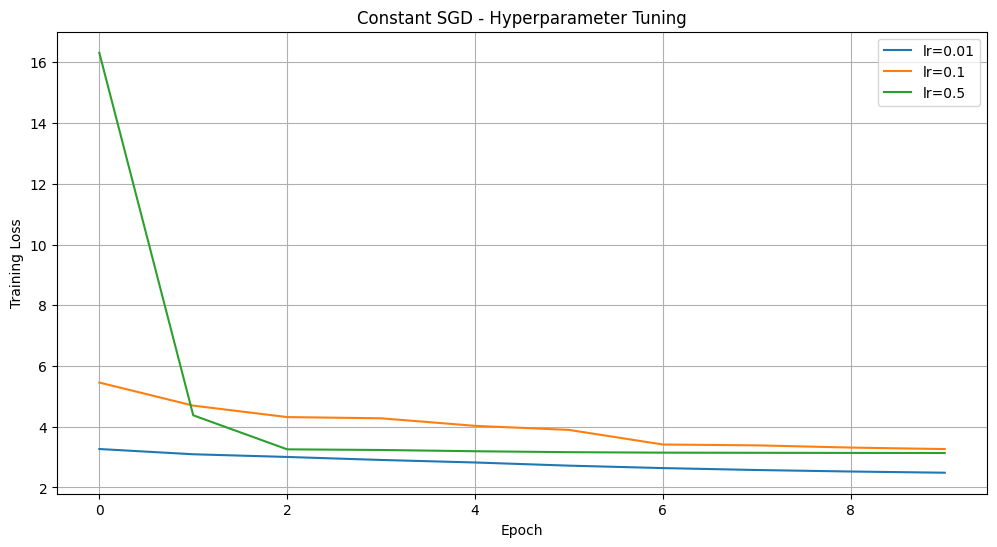

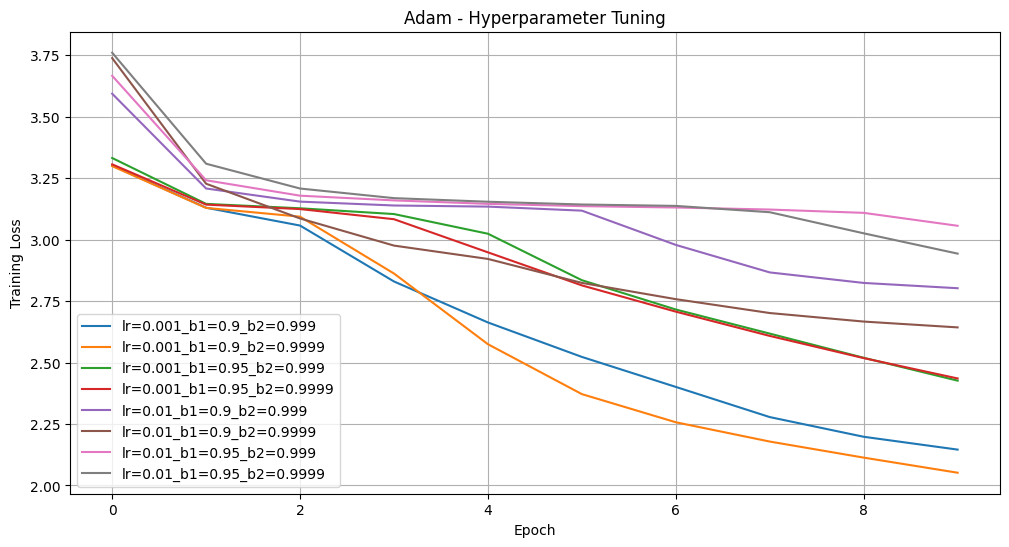

In [30]:
best_params, sgd_tuning, adam_tuning = tune_hyperparameters()

plot_tuning_results(sgd_tuning, optimizer_name="Constant SGD")
plot_tuning_results(adam_tuning, optimizer_name="Adam")



--- Comparing Optimizers with Batch Size 16 ---
Training with Constant SGD: lr=0.01, batch_size=16


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 1: Train Loss = 3.0701, Val Loss = 2.9279


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 2: Train Loss = 2.6946, Val Loss = 2.4934


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 3: Train Loss = 2.4737, Val Loss = 2.3133


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 4: Train Loss = 2.3422, Val Loss = 2.2197


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 5: Train Loss = 2.2648, Val Loss = 2.1619


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 6: Train Loss = 2.2057, Val Loss = 2.1247


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 7: Train Loss = 2.1741, Val Loss = 2.0920


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 8: Train Loss = 2.1457, Val Loss = 2.0702


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 9: Train Loss = 2.1196, Val Loss = 2.0522


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 10: Train Loss = 2.1039, Val Loss = 2.0371
Training with Polyak SGD: epsilon=1e-08, batch_size=16


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 1: Train Loss = 5.0393, Val Loss = 3.9239


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 2: Train Loss = 4.2690, Val Loss = 3.5767


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 3: Train Loss = 4.4525, Val Loss = 4.6000


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 4: Train Loss = 4.2530, Val Loss = 6.8426


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 5: Train Loss = 4.3833, Val Loss = 3.8186


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 6: Train Loss = 4.3838, Val Loss = 2.9583


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 7: Train Loss = 4.1086, Val Loss = 2.8893


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 8: Train Loss = 3.8226, Val Loss = 3.6643


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 9: Train Loss = 3.5529, Val Loss = 4.9055


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 10: Train Loss = 3.7018, Val Loss = 2.7606
Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=16


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 1: Train Loss = 3.1695, Val Loss = 3.0234


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 2: Train Loss = 2.5169, Val Loss = 2.2006


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 3: Train Loss = 2.1594, Val Loss = 2.0729


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 4: Train Loss = 2.0425, Val Loss = 1.9055


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 5: Train Loss = 1.8099, Val Loss = 1.4954


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 6: Train Loss = 1.4007, Val Loss = 0.9943


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 7: Train Loss = 1.0327, Val Loss = 0.7093


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 8: Train Loss = 0.8126, Val Loss = 0.5800


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 9: Train Loss = 0.6944, Val Loss = 0.5167


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 10: Train Loss = 0.6257, Val Loss = 0.4862

--- Comparing Optimizers with Batch Size 32 ---
Training with Constant SGD: lr=0.01, batch_size=32


100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


Epoch 1: Train Loss = 3.1849, Val Loss = 3.0338


100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


Epoch 2: Train Loss = 2.9983, Val Loss = 2.9452


100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


Epoch 3: Train Loss = 2.7994, Val Loss = 2.5797


100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Epoch 4: Train Loss = 2.6235, Val Loss = 2.4921


100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Epoch 5: Train Loss = 2.5074, Val Loss = 2.3759


100%|██████████| 27/27 [00:06<00:00,  4.38it/s]


Epoch 6: Train Loss = 2.4307, Val Loss = 2.3094


100%|██████████| 27/27 [00:06<00:00,  4.38it/s]


Epoch 7: Train Loss = 2.3705, Val Loss = 2.2611


100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Epoch 8: Train Loss = 2.3234, Val Loss = 2.2226


100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Epoch 9: Train Loss = 2.2763, Val Loss = 2.1916


100%|██████████| 27/27 [00:06<00:00,  4.37it/s]


Epoch 10: Train Loss = 2.2505, Val Loss = 2.1643
Training with Polyak SGD: epsilon=1e-08, batch_size=32


100%|██████████| 27/27 [00:06<00:00,  4.25it/s]


Epoch 1: Train Loss = 5.2235, Val Loss = 4.1262


100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


Epoch 2: Train Loss = 4.8734, Val Loss = 3.8787


100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Epoch 3: Train Loss = 4.5692, Val Loss = 3.0781


100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


Epoch 4: Train Loss = 4.8209, Val Loss = 3.9404


100%|██████████| 27/27 [00:06<00:00,  4.25it/s]


Epoch 5: Train Loss = 5.9014, Val Loss = 3.8032


100%|██████████| 27/27 [00:06<00:00,  4.23it/s]


Epoch 6: Train Loss = 3.7095, Val Loss = 3.9162


100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Epoch 7: Train Loss = 4.0826, Val Loss = 4.1668


100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Epoch 8: Train Loss = 4.1234, Val Loss = 3.2987


100%|██████████| 27/27 [00:06<00:00,  4.25it/s]


Epoch 9: Train Loss = 3.5271, Val Loss = 4.5823


100%|██████████| 27/27 [00:06<00:00,  4.25it/s]


Epoch 10: Train Loss = 4.8789, Val Loss = 3.6098
Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=32


100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


Epoch 1: Train Loss = 3.2220, Val Loss = 3.1183


100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Epoch 2: Train Loss = 2.9887, Val Loss = 2.8299


100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Epoch 3: Train Loss = 2.6899, Val Loss = 2.4953


100%|██████████| 27/27 [00:06<00:00,  4.23it/s]


Epoch 4: Train Loss = 2.3539, Val Loss = 2.1920


100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


Epoch 5: Train Loss = 2.1640, Val Loss = 2.0902


100%|██████████| 27/27 [00:06<00:00,  4.19it/s]


Epoch 6: Train Loss = 2.0795, Val Loss = 2.0031


100%|██████████| 27/27 [00:06<00:00,  4.20it/s]


Epoch 7: Train Loss = 1.9790, Val Loss = 1.8454


100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


Epoch 8: Train Loss = 1.7918, Val Loss = 1.5424


100%|██████████| 27/27 [00:06<00:00,  4.23it/s]


Epoch 9: Train Loss = 1.5134, Val Loss = 1.2210


100%|██████████| 27/27 [00:06<00:00,  4.20it/s]


Epoch 10: Train Loss = 1.2418, Val Loss = 0.9683

--- Comparing Optimizers with Batch Size 64 ---
Training with Constant SGD: lr=0.01, batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 1: Train Loss = 3.2540, Val Loss = 3.0825


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 2: Train Loss = 3.0869, Val Loss = 2.9868


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 3: Train Loss = 2.9976, Val Loss = 2.8638


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 4: Train Loss = 2.9288, Val Loss = 2.7860


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 5: Train Loss = 2.8028, Val Loss = 2.6508


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 6: Train Loss = 2.7259, Val Loss = 2.5900


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 7: Train Loss = 2.6365, Val Loss = 2.5009


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 8: Train Loss = 2.5859, Val Loss = 2.4766


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


Epoch 9: Train Loss = 2.5274, Val Loss = 2.4068


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Epoch 10: Train Loss = 2.4830, Val Loss = 2.3780
Training with Polyak SGD: epsilon=1e-08, batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 1: Train Loss = 5.1719, Val Loss = 3.8007


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 2: Train Loss = 5.0517, Val Loss = 5.2502


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 3: Train Loss = 4.8887, Val Loss = 4.2018


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 4: Train Loss = 5.0608, Val Loss = 3.3610


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 5: Train Loss = 4.7491, Val Loss = 4.8432


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 6: Train Loss = 4.5355, Val Loss = 6.7261


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 7: Train Loss = 5.3194, Val Loss = 4.6109


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 8: Train Loss = 4.4979, Val Loss = 10.1576


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 9: Train Loss = 4.8549, Val Loss = 3.3440


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 10: Train Loss = 4.0284, Val Loss = 3.4060
Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=64


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 1: Train Loss = 3.3206, Val Loss = 3.1376


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 2: Train Loss = 3.1284, Val Loss = 3.1087


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 3: Train Loss = 3.0614, Val Loss = 2.9433


100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch 4: Train Loss = 2.8511, Val Loss = 2.7962


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 5: Train Loss = 2.7355, Val Loss = 2.6032


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch 6: Train Loss = 2.5394, Val Loss = 2.4278


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 7: Train Loss = 2.3706, Val Loss = 2.2737


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch 8: Train Loss = 2.2594, Val Loss = 2.1808


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 9: Train Loss = 2.1862, Val Loss = 2.1251


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch 10: Train Loss = 2.1360, Val Loss = 2.0876

--- Comparing Optimizers with Batch Size 128 ---
Training with Constant SGD: lr=0.01, batch_size=128


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 1: Train Loss = 3.4107, Val Loss = 3.1760


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 2: Train Loss = 3.1795, Val Loss = 3.1102


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 3: Train Loss = 3.1239, Val Loss = 3.0617


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 4: Train Loss = 3.0820, Val Loss = 3.0143


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 5: Train Loss = 3.0454, Val Loss = 2.9652


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 6: Train Loss = 3.0034, Val Loss = 2.9016


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 7: Train Loss = 2.9561, Val Loss = 2.8287


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 8: Train Loss = 2.9510, Val Loss = 2.8585


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 9: Train Loss = 2.8915, Val Loss = 2.7262


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 10: Train Loss = 2.8231, Val Loss = 2.6733
Training with Polyak SGD: epsilon=1e-08, batch_size=128


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 1: Train Loss = 5.0221, Val Loss = 4.2143


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 2: Train Loss = 4.9657, Val Loss = 3.9784


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 3: Train Loss = 4.3071, Val Loss = 4.9561


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 4: Train Loss = 4.7381, Val Loss = 4.0955


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 5: Train Loss = 4.9827, Val Loss = 4.1370


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 6: Train Loss = 4.9601, Val Loss = 3.9710


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 7: Train Loss = 4.8746, Val Loss = 3.8345


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 8: Train Loss = 5.0768, Val Loss = 4.5411


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 9: Train Loss = 4.5214, Val Loss = 3.9884


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 10: Train Loss = 3.9225, Val Loss = 5.3299
Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=128


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 1: Train Loss = 3.4360, Val Loss = 3.1446


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 2: Train Loss = 3.1539, Val Loss = 3.1388


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 3: Train Loss = 3.1319, Val Loss = 3.1350


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 4: Train Loss = 3.1197, Val Loss = 3.1012


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 5: Train Loss = 3.0893, Val Loss = 3.0539


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch 6: Train Loss = 3.0131, Val Loss = 2.9250


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 7: Train Loss = 2.8664, Val Loss = 2.8129


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 8: Train Loss = 2.7747, Val Loss = 2.7160


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 9: Train Loss = 2.6875, Val Loss = 2.6369


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch 10: Train Loss = 2.6169, Val Loss = 2.5519


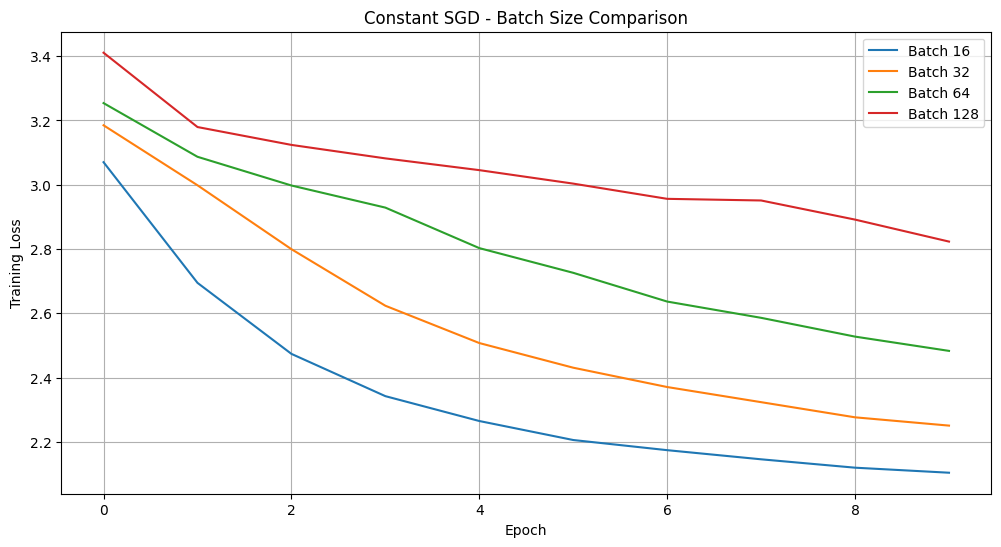

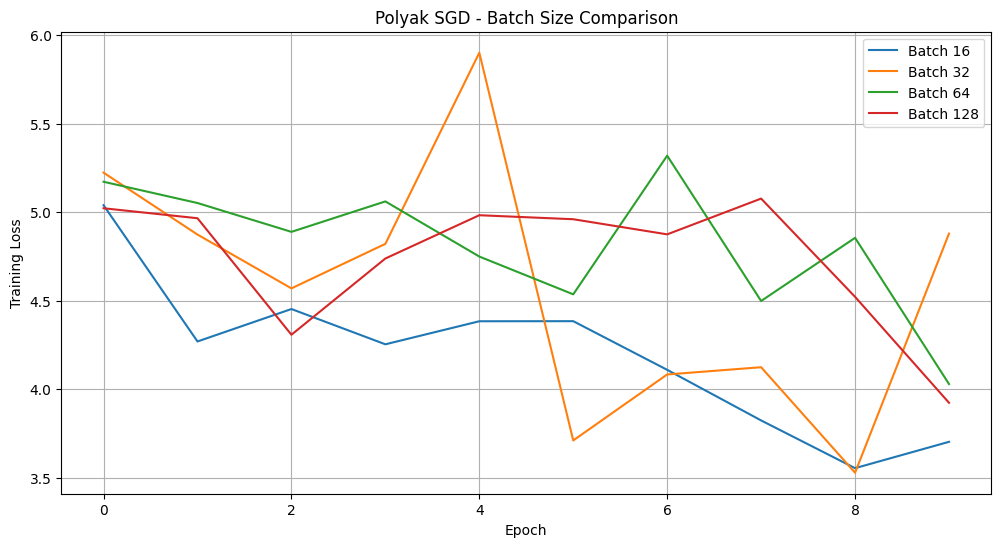

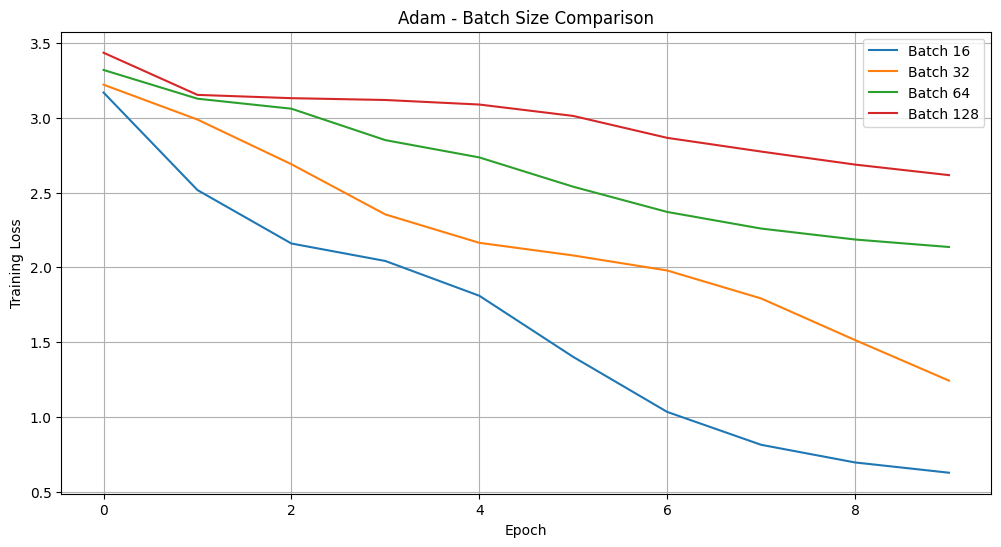

In [31]:
batch_comparison = compare_batch_sizes(batch_size_options, best_params)

plot_batchsize_comparison(batch_comparison)


In [34]:


sgd_model = GPTLanguageModel().to(device)
sgd_results = train_constant_sgd(sgd_model, batch_size=16, lr=0.01, max_epochs=200)



Training with Constant SGD: lr=0.01, batch_size=16


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 1: Train Loss = 3.0713, Val Loss = 2.7530


100%|██████████| 54/54 [00:06<00:00,  7.93it/s]


Epoch 2: Train Loss = 2.6759, Val Loss = 2.4418


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Epoch 3: Train Loss = 2.4521, Val Loss = 2.2913


100%|██████████| 54/54 [00:06<00:00,  8.00it/s]


Epoch 4: Train Loss = 2.3291, Val Loss = 2.2063


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 5: Train Loss = 2.2494, Val Loss = 2.1527


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 6: Train Loss = 2.2023, Val Loss = 2.1213


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 7: Train Loss = 2.1682, Val Loss = 2.0898


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 8: Train Loss = 2.1420, Val Loss = 2.0670


100%|██████████| 54/54 [00:06<00:00,  7.95it/s]


Epoch 9: Train Loss = 2.1200, Val Loss = 2.0498


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 10: Train Loss = 2.1037, Val Loss = 2.0376


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 11: Train Loss = 2.0906, Val Loss = 2.0222


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 12: Train Loss = 2.0729, Val Loss = 2.0103


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 13: Train Loss = 2.0609, Val Loss = 1.9990


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 14: Train Loss = 2.0528, Val Loss = 1.9910


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 15: Train Loss = 2.0439, Val Loss = 1.9823


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 16: Train Loss = 2.0368, Val Loss = 1.9747


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 17: Train Loss = 2.0280, Val Loss = 1.9646


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 18: Train Loss = 2.0215, Val Loss = 1.9595


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 19: Train Loss = 2.0173, Val Loss = 1.9504


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 20: Train Loss = 2.0055, Val Loss = 1.9470


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 21: Train Loss = 2.0017, Val Loss = 1.9418


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 22: Train Loss = 1.9909, Val Loss = 1.9306


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 23: Train Loss = 1.9848, Val Loss = 1.9276


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 24: Train Loss = 1.9789, Val Loss = 1.9141


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 25: Train Loss = 1.9740, Val Loss = 1.9135


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 26: Train Loss = 1.9712, Val Loss = 1.9045


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 27: Train Loss = 1.9647, Val Loss = 1.8984


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 28: Train Loss = 1.9558, Val Loss = 1.8889


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 29: Train Loss = 1.9529, Val Loss = 1.8841


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 30: Train Loss = 1.9454, Val Loss = 1.8788


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 31: Train Loss = 1.9367, Val Loss = 1.8697


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 32: Train Loss = 1.9331, Val Loss = 1.8613


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 33: Train Loss = 1.9291, Val Loss = 1.8563


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 34: Train Loss = 1.9212, Val Loss = 1.8435


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 35: Train Loss = 1.9170, Val Loss = 1.8409


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 36: Train Loss = 1.9076, Val Loss = 1.8361


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 37: Train Loss = 1.9026, Val Loss = 1.8351


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Epoch 38: Train Loss = 1.8972, Val Loss = 1.8191


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 39: Train Loss = 1.8936, Val Loss = 1.8155


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 40: Train Loss = 1.8869, Val Loss = 1.8055


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 41: Train Loss = 1.8781, Val Loss = 1.7956


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 42: Train Loss = 1.8738, Val Loss = 1.7844


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 43: Train Loss = 1.8693, Val Loss = 1.7791


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 44: Train Loss = 1.8635, Val Loss = 1.7701


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 45: Train Loss = 1.8568, Val Loss = 1.7750


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 46: Train Loss = 1.8472, Val Loss = 1.7577


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 47: Train Loss = 1.8450, Val Loss = 1.7509


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 48: Train Loss = 1.8358, Val Loss = 1.7432


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Epoch 49: Train Loss = 1.8295, Val Loss = 1.7429


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 50: Train Loss = 1.8289, Val Loss = 1.7275


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 51: Train Loss = 1.8182, Val Loss = 1.7131


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 52: Train Loss = 1.8120, Val Loss = 1.7065


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 53: Train Loss = 1.8075, Val Loss = 1.6962


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 54: Train Loss = 1.8013, Val Loss = 1.6959


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Epoch 55: Train Loss = 1.7967, Val Loss = 1.6785


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 56: Train Loss = 1.7835, Val Loss = 1.6734


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 57: Train Loss = 1.7841, Val Loss = 1.6648


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 58: Train Loss = 1.7750, Val Loss = 1.6544


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 59: Train Loss = 1.7693, Val Loss = 1.6379


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 60: Train Loss = 1.7634, Val Loss = 1.6354


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 61: Train Loss = 1.7558, Val Loss = 1.6273


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 62: Train Loss = 1.7472, Val Loss = 1.6230


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 63: Train Loss = 1.7388, Val Loss = 1.6043


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 64: Train Loss = 1.7333, Val Loss = 1.6034


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 65: Train Loss = 1.7286, Val Loss = 1.5883


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 66: Train Loss = 1.7229, Val Loss = 1.5749


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 67: Train Loss = 1.7175, Val Loss = 1.5871


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 68: Train Loss = 1.7054, Val Loss = 1.5583


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 69: Train Loss = 1.7014, Val Loss = 1.5624


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 70: Train Loss = 1.6925, Val Loss = 1.5493


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 71: Train Loss = 1.6910, Val Loss = 1.5280


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 72: Train Loss = 1.6771, Val Loss = 1.5188


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 73: Train Loss = 1.6673, Val Loss = 1.5128


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 74: Train Loss = 1.6639, Val Loss = 1.5070


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 75: Train Loss = 1.6529, Val Loss = 1.4938


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 76: Train Loss = 1.6468, Val Loss = 1.4749


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 77: Train Loss = 1.6343, Val Loss = 1.4824


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 78: Train Loss = 1.6272, Val Loss = 1.4531


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 79: Train Loss = 1.6220, Val Loss = 1.4422


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 80: Train Loss = 1.6115, Val Loss = 1.4259


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 81: Train Loss = 1.6044, Val Loss = 1.4272


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 82: Train Loss = 1.5854, Val Loss = 1.4074


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 83: Train Loss = 1.5746, Val Loss = 1.4125


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 84: Train Loss = 1.5739, Val Loss = 1.3761


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 85: Train Loss = 1.5591, Val Loss = 1.3677


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 86: Train Loss = 1.5450, Val Loss = 1.3520


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 87: Train Loss = 1.5276, Val Loss = 1.3287


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 88: Train Loss = 1.5142, Val Loss = 1.3078


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 89: Train Loss = 1.5024, Val Loss = 1.3139


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 90: Train Loss = 1.4755, Val Loss = 1.2758


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 91: Train Loss = 1.4593, Val Loss = 1.2487


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 92: Train Loss = 1.4442, Val Loss = 1.2264


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 93: Train Loss = 1.4122, Val Loss = 1.2021


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 94: Train Loss = 1.3958, Val Loss = 1.2212


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 95: Train Loss = 1.3624, Val Loss = 1.1349


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 96: Train Loss = 1.3292, Val Loss = 1.0798


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 97: Train Loss = 1.2865, Val Loss = 1.0409


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Epoch 98: Train Loss = 1.2466, Val Loss = 1.0041


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 99: Train Loss = 1.2034, Val Loss = 0.9438


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 100: Train Loss = 1.1463, Val Loss = 0.8787


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 101: Train Loss = 1.1149, Val Loss = 0.8805


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 102: Train Loss = 1.0598, Val Loss = 0.7976


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 103: Train Loss = 1.0293, Val Loss = 0.8097


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 104: Train Loss = 0.9775, Val Loss = 0.7406


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 105: Train Loss = 0.9536, Val Loss = 0.7132


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 106: Train Loss = 0.9194, Val Loss = 0.6748


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 107: Train Loss = 0.8789, Val Loss = 0.6432


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 108: Train Loss = 0.8577, Val Loss = 0.6194


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 109: Train Loss = 0.8286, Val Loss = 0.5990


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 110: Train Loss = 0.8063, Val Loss = 0.6045


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 111: Train Loss = 0.7865, Val Loss = 0.6331


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 112: Train Loss = 0.7819, Val Loss = 0.5383


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 113: Train Loss = 0.7445, Val Loss = 0.5463


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 114: Train Loss = 0.7356, Val Loss = 0.5099


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Epoch 115: Train Loss = 0.7069, Val Loss = 0.5427


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 116: Train Loss = 0.7005, Val Loss = 0.5174


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 117: Train Loss = 0.6767, Val Loss = 0.4852


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 118: Train Loss = 0.6682, Val Loss = 0.4856


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 119: Train Loss = 0.6749, Val Loss = 0.4859


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 120: Train Loss = 0.6519, Val Loss = 0.5255


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 121: Train Loss = 0.6282, Val Loss = 0.4673


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 122: Train Loss = 0.6233, Val Loss = 0.4403


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 123: Train Loss = 0.6123, Val Loss = 0.4845


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 124: Train Loss = 0.5954, Val Loss = 0.4337


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 125: Train Loss = 0.5985, Val Loss = 0.4554


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 126: Train Loss = 0.5941, Val Loss = 0.4316


100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Epoch 127: Train Loss = 0.5761, Val Loss = 0.4260


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 128: Train Loss = 0.5881, Val Loss = 0.4207


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 129: Train Loss = 0.5445, Val Loss = 0.4399


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 130: Train Loss = 0.5751, Val Loss = 0.4293


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 131: Train Loss = 0.5411, Val Loss = 0.4151


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 132: Train Loss = 0.5976, Val Loss = 0.4911


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 133: Train Loss = 0.5311, Val Loss = 0.4148


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 134: Train Loss = 0.5399, Val Loss = 0.4107


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 135: Train Loss = 0.5304, Val Loss = 0.4325


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 136: Train Loss = 0.5189, Val Loss = 0.4338


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 137: Train Loss = 0.5183, Val Loss = 0.4185


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 138: Train Loss = 0.5142, Val Loss = 0.4014


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 139: Train Loss = 0.5115, Val Loss = 0.4162


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 140: Train Loss = 0.6256, Val Loss = 0.4165


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 141: Train Loss = 0.4899, Val Loss = 0.4031


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 142: Train Loss = 0.5101, Val Loss = 0.3994


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 143: Train Loss = 0.4891, Val Loss = 0.3953


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 144: Train Loss = 0.5039, Val Loss = 0.3823


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 145: Train Loss = 0.5108, Val Loss = 0.3846


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 146: Train Loss = 0.4795, Val Loss = 0.3829


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 147: Train Loss = 0.4812, Val Loss = 0.3937


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 148: Train Loss = 0.4971, Val Loss = 0.3904


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 149: Train Loss = 0.5164, Val Loss = 1.1378


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 150: Train Loss = 0.8088, Val Loss = 0.4193


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 151: Train Loss = 0.5219, Val Loss = 0.3992


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 152: Train Loss = 0.5181, Val Loss = 0.4016


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 153: Train Loss = 0.5038, Val Loss = 0.4328


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 154: Train Loss = 0.4917, Val Loss = 0.3896


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 155: Train Loss = 0.5106, Val Loss = 0.4118


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 156: Train Loss = 0.4742, Val Loss = 0.3820


100%|██████████| 54/54 [00:06<00:00,  8.08it/s]


Epoch 157: Train Loss = 0.4651, Val Loss = 0.4037


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 158: Train Loss = 0.4716, Val Loss = 0.3811


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 159: Train Loss = 0.4612, Val Loss = 0.3790


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 160: Train Loss = 0.4666, Val Loss = 0.3824


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 161: Train Loss = 0.4612, Val Loss = 0.4085


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 162: Train Loss = 0.4571, Val Loss = 0.3830


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 163: Train Loss = 0.4518, Val Loss = 0.3877


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 164: Train Loss = 0.4533, Val Loss = 0.3809


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 165: Train Loss = 0.4415, Val Loss = 0.3732


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 166: Train Loss = 0.4549, Val Loss = 0.3762


100%|██████████| 54/54 [00:06<00:00,  8.18it/s]


Epoch 167: Train Loss = 0.4652, Val Loss = 0.4280


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 168: Train Loss = 0.4346, Val Loss = 0.3772


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 169: Train Loss = 0.4415, Val Loss = 0.3709


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 170: Train Loss = 0.4305, Val Loss = 0.3688


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 171: Train Loss = 0.4445, Val Loss = 0.3822


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 172: Train Loss = 0.4535, Val Loss = 0.3648


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 173: Train Loss = 0.4308, Val Loss = 0.3686


100%|██████████| 54/54 [00:06<00:00,  8.06it/s]


Epoch 174: Train Loss = 0.4282, Val Loss = 0.3694


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Epoch 175: Train Loss = 0.4311, Val Loss = 0.3729


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 176: Train Loss = 0.4354, Val Loss = 0.3673


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 177: Train Loss = 0.8229, Val Loss = 0.4262


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 178: Train Loss = 0.4715, Val Loss = 0.3794


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 179: Train Loss = 0.4489, Val Loss = 0.3847


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 180: Train Loss = 0.4620, Val Loss = 0.3772


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 181: Train Loss = 0.4531, Val Loss = 0.4506


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 182: Train Loss = 0.4434, Val Loss = 0.3717


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 183: Train Loss = 0.4448, Val Loss = 0.3694


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 184: Train Loss = 0.4350, Val Loss = 0.3676


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 185: Train Loss = 0.4487, Val Loss = 0.4185


100%|██████████| 54/54 [00:06<00:00,  8.06it/s]


Epoch 186: Train Loss = 0.4417, Val Loss = 0.3760


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 187: Train Loss = 0.4541, Val Loss = 0.3710


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Epoch 188: Train Loss = 0.4244, Val Loss = 0.3694


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 189: Train Loss = 0.5718, Val Loss = 0.4339


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 190: Train Loss = 0.4799, Val Loss = 0.4023


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 191: Train Loss = 0.4359, Val Loss = 0.3725


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 192: Train Loss = 0.4368, Val Loss = 0.4463


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 193: Train Loss = 0.4328, Val Loss = 0.3666


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


Epoch 194: Train Loss = 0.4269, Val Loss = 0.3636


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Epoch 195: Train Loss = 0.4355, Val Loss = 0.3623


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Epoch 196: Train Loss = 0.4312, Val Loss = 0.3623


100%|██████████| 54/54 [00:06<00:00,  8.06it/s]


Epoch 197: Train Loss = 0.4281, Val Loss = 0.4162


100%|██████████| 54/54 [00:06<00:00,  8.11it/s]


Epoch 198: Train Loss = 0.4319, Val Loss = 0.3637


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


Epoch 199: Train Loss = 0.4418, Val Loss = 0.4652


100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Epoch 200: Train Loss = 0.6022, Val Loss = 0.3704


In [35]:
polyak_model = GPTLanguageModel().to(device)
polyak_results = train_polyak_sgd(polyak_model, batch_size=16, epsilon=1e-8, max_epochs=200)


Training with Polyak SGD: epsilon=1e-08, batch_size=16


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 1: Train Loss = 5.1821, Val Loss = 6.5365


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 2: Train Loss = 4.7940, Val Loss = 6.2553


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 3: Train Loss = 4.5224, Val Loss = 3.6603


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 4: Train Loss = 4.4179, Val Loss = 4.7283


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 5: Train Loss = 4.0188, Val Loss = 4.6684


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 6: Train Loss = 3.8522, Val Loss = 3.8656


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 7: Train Loss = 3.9949, Val Loss = 2.7725


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 8: Train Loss = 3.8715, Val Loss = 2.9998


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 9: Train Loss = 3.8413, Val Loss = 2.7437


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 10: Train Loss = 3.6726, Val Loss = 4.2810


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 11: Train Loss = 3.6269, Val Loss = 2.5488


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 12: Train Loss = 3.4725, Val Loss = 4.7557


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 13: Train Loss = 3.4999, Val Loss = 5.7531


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 14: Train Loss = 3.3484, Val Loss = 3.1414


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 15: Train Loss = 3.2495, Val Loss = 2.7050


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 16: Train Loss = 3.2358, Val Loss = 4.3552


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 17: Train Loss = 3.2204, Val Loss = 3.1441


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 18: Train Loss = 3.1244, Val Loss = 2.9282


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 19: Train Loss = 3.0753, Val Loss = 3.2171


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 20: Train Loss = 3.1601, Val Loss = 3.3787


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 21: Train Loss = 3.2107, Val Loss = 2.5249


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 22: Train Loss = 2.9586, Val Loss = 2.9541


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 23: Train Loss = 2.9601, Val Loss = 4.0546


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 24: Train Loss = 3.0874, Val Loss = 3.5773


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 25: Train Loss = 3.1496, Val Loss = 3.0561


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 26: Train Loss = 3.1378, Val Loss = 3.3693


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 27: Train Loss = 2.9444, Val Loss = 2.6678


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 28: Train Loss = 3.0392, Val Loss = 2.8677


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 29: Train Loss = 2.9018, Val Loss = 2.9184


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 30: Train Loss = 3.1245, Val Loss = 4.6516


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 31: Train Loss = 3.0106, Val Loss = 3.2124


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 32: Train Loss = 2.9945, Val Loss = 2.7511


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 33: Train Loss = 3.0220, Val Loss = 2.7995


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 34: Train Loss = 2.9812, Val Loss = 6.1704


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 35: Train Loss = 3.0514, Val Loss = 3.0530


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 36: Train Loss = 2.9447, Val Loss = 2.3756


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 37: Train Loss = 3.1055, Val Loss = 2.8692


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 38: Train Loss = 3.0220, Val Loss = 3.1782


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 39: Train Loss = 3.0878, Val Loss = 3.2798


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 40: Train Loss = 2.9126, Val Loss = 2.3865


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 41: Train Loss = 2.8997, Val Loss = 2.4018


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 42: Train Loss = 3.0066, Val Loss = 2.5440


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 43: Train Loss = 3.0132, Val Loss = 4.7757


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 44: Train Loss = 3.0542, Val Loss = 3.9161


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 45: Train Loss = 2.9122, Val Loss = 3.3515


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 46: Train Loss = 3.3658, Val Loss = 2.4548


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 47: Train Loss = 2.9716, Val Loss = 2.3171


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 48: Train Loss = 2.9944, Val Loss = 2.9899


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 49: Train Loss = 2.9725, Val Loss = 3.0018


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 50: Train Loss = 2.8883, Val Loss = 2.5056


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 51: Train Loss = 2.8949, Val Loss = 3.6779


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 52: Train Loss = 2.9987, Val Loss = 2.3898


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 53: Train Loss = 3.0709, Val Loss = 3.1990


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 54: Train Loss = 3.0460, Val Loss = 2.4624


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 55: Train Loss = 2.8330, Val Loss = 3.4333


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 56: Train Loss = 2.9373, Val Loss = 2.6889


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 57: Train Loss = 2.9418, Val Loss = 2.3539


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 58: Train Loss = 2.9010, Val Loss = 2.4073


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 59: Train Loss = 2.8876, Val Loss = 2.8454


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 60: Train Loss = 2.9376, Val Loss = 2.6326


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 61: Train Loss = 2.9974, Val Loss = 3.6150


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 62: Train Loss = 2.9596, Val Loss = 2.9306


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 63: Train Loss = 2.9827, Val Loss = 2.9004


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 64: Train Loss = 2.9736, Val Loss = 3.4247


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 65: Train Loss = 2.9926, Val Loss = 3.5093


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 66: Train Loss = 3.0381, Val Loss = 3.1408


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 67: Train Loss = 2.9218, Val Loss = 3.1946


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 68: Train Loss = 2.9507, Val Loss = 2.7084


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 69: Train Loss = 2.9380, Val Loss = 2.9959


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 70: Train Loss = 2.9529, Val Loss = 2.6262


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 71: Train Loss = 2.9193, Val Loss = 2.8431


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 72: Train Loss = 2.8299, Val Loss = 2.5277


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 73: Train Loss = 2.8149, Val Loss = 2.6737


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 74: Train Loss = 2.8812, Val Loss = 4.4749


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 75: Train Loss = 2.8270, Val Loss = 2.4428


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


Epoch 76: Train Loss = 2.8392, Val Loss = 3.1512


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 77: Train Loss = 2.8201, Val Loss = 3.5634


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 78: Train Loss = 2.7389, Val Loss = 2.7117


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 79: Train Loss = 2.8195, Val Loss = 2.3371


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 80: Train Loss = 2.6769, Val Loss = 2.2552


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 81: Train Loss = 2.6984, Val Loss = 2.1881


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 82: Train Loss = 2.6709, Val Loss = 2.3266


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 83: Train Loss = 2.6176, Val Loss = 2.2390


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 84: Train Loss = 2.6387, Val Loss = 2.4721


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 85: Train Loss = 2.5021, Val Loss = 2.7047


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 86: Train Loss = 2.4105, Val Loss = 2.2740


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 87: Train Loss = 2.3991, Val Loss = 2.0445


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 88: Train Loss = 2.2318, Val Loss = 2.2424


100%|██████████| 54/54 [00:06<00:00,  7.74it/s]


Epoch 89: Train Loss = 2.1570, Val Loss = 1.7092


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 90: Train Loss = 2.0179, Val Loss = 1.8846


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 91: Train Loss = 1.9328, Val Loss = 1.8035


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 92: Train Loss = 1.8343, Val Loss = 1.6998


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 93: Train Loss = 1.6856, Val Loss = 2.1534


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 94: Train Loss = 1.5525, Val Loss = 2.0730


100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


Epoch 95: Train Loss = 1.3870, Val Loss = 1.3792


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 96: Train Loss = 1.2640, Val Loss = 1.6718


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 97: Train Loss = 1.1654, Val Loss = 1.0463


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 98: Train Loss = 1.0637, Val Loss = 1.0508


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 99: Train Loss = 0.9834, Val Loss = 1.1129


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 100: Train Loss = 0.9145, Val Loss = 0.8874


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 101: Train Loss = 0.8529, Val Loss = 0.7607


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 102: Train Loss = 0.8111, Val Loss = 0.7248


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 103: Train Loss = 0.7557, Val Loss = 0.5344


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 104: Train Loss = 0.7201, Val Loss = 0.4696


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 105: Train Loss = 0.7017, Val Loss = 0.4632


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 106: Train Loss = 0.6777, Val Loss = 0.4844


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 107: Train Loss = 0.6515, Val Loss = 0.4422


100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


Epoch 108: Train Loss = 0.6552, Val Loss = 0.4966


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 109: Train Loss = 0.6176, Val Loss = 0.4274


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 110: Train Loss = 0.6073, Val Loss = 0.4187


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 111: Train Loss = 0.5948, Val Loss = 0.4204


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 112: Train Loss = 0.5636, Val Loss = 0.4088


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 113: Train Loss = 0.5560, Val Loss = 0.4995


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


Epoch 114: Train Loss = 0.5527, Val Loss = 0.6428


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 115: Train Loss = 0.5390, Val Loss = 0.5227


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 116: Train Loss = 0.5194, Val Loss = 0.4045


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


Epoch 117: Train Loss = 0.5109, Val Loss = 0.3924


100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


Epoch 118: Train Loss = 0.5119, Val Loss = 0.4279


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 119: Train Loss = 0.4917, Val Loss = 0.3776


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 120: Train Loss = 0.4856, Val Loss = 0.3833


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 121: Train Loss = 0.4713, Val Loss = 0.3846


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 122: Train Loss = 0.4602, Val Loss = 0.4548


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 123: Train Loss = 0.4561, Val Loss = 0.3988


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 124: Train Loss = 0.4467, Val Loss = 0.3661


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 125: Train Loss = 0.4446, Val Loss = 0.3593


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 126: Train Loss = 0.4316, Val Loss = 0.4009


100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


Epoch 127: Train Loss = 0.4229, Val Loss = 0.3609


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 128: Train Loss = 0.4252, Val Loss = 0.3570


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 129: Train Loss = 0.4254, Val Loss = 0.3531


100%|██████████| 54/54 [00:06<00:00,  7.75it/s]


Epoch 130: Train Loss = 0.4123, Val Loss = 0.3606


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 131: Train Loss = 0.4108, Val Loss = 0.3593


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 132: Train Loss = 0.4121, Val Loss = 0.3662


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 133: Train Loss = 0.4041, Val Loss = 0.3492


100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


Epoch 134: Train Loss = 0.4077, Val Loss = 0.3864


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 135: Train Loss = 0.4090, Val Loss = 0.3528


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 136: Train Loss = 0.3964, Val Loss = 0.3905


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 137: Train Loss = 0.4047, Val Loss = 0.3675


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 138: Train Loss = 0.3950, Val Loss = 0.3966


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 139: Train Loss = 0.3999, Val Loss = 0.4287


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 140: Train Loss = 0.3989, Val Loss = 0.3559


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 141: Train Loss = 0.3930, Val Loss = 0.3998


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 142: Train Loss = 0.4035, Val Loss = 0.3613


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 143: Train Loss = 0.3955, Val Loss = 0.3670


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 144: Train Loss = 0.3866, Val Loss = 0.3822


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 145: Train Loss = 0.3857, Val Loss = 0.3665


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


Epoch 146: Train Loss = 0.3895, Val Loss = 0.3699


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 147: Train Loss = 0.3894, Val Loss = 0.4467


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 148: Train Loss = 0.3903, Val Loss = 0.3651


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 149: Train Loss = 0.3859, Val Loss = 0.3500


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 150: Train Loss = 0.3898, Val Loss = 0.3476


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 151: Train Loss = 0.3963, Val Loss = 0.3474


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 152: Train Loss = 0.3867, Val Loss = 0.3561


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 153: Train Loss = 0.3852, Val Loss = 0.3526


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 154: Train Loss = 0.3847, Val Loss = 0.3572


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 155: Train Loss = 0.3876, Val Loss = 0.3616


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 156: Train Loss = 0.3835, Val Loss = 0.3589


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 157: Train Loss = 0.3861, Val Loss = 0.4026


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 158: Train Loss = 0.3898, Val Loss = 0.3614


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 159: Train Loss = 0.3846, Val Loss = 0.3455


100%|██████████| 54/54 [00:07<00:00,  7.33it/s]


Epoch 160: Train Loss = 0.3810, Val Loss = 0.3517


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 161: Train Loss = 0.3996, Val Loss = 0.3419


100%|██████████| 54/54 [00:07<00:00,  7.70it/s]


Epoch 162: Train Loss = 0.3903, Val Loss = 0.3603


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 163: Train Loss = 0.3832, Val Loss = 0.3945


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 164: Train Loss = 0.3913, Val Loss = 0.3422


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 165: Train Loss = 0.3822, Val Loss = 0.3436


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 166: Train Loss = 0.3827, Val Loss = 0.3683


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 167: Train Loss = 0.3916, Val Loss = 0.3466


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 168: Train Loss = 0.3852, Val Loss = 0.3486


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


Epoch 169: Train Loss = 0.3851, Val Loss = 0.4710


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 170: Train Loss = 0.4027, Val Loss = 0.4034


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 171: Train Loss = 0.3881, Val Loss = 0.3510


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 172: Train Loss = 0.3835, Val Loss = 0.3438


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 173: Train Loss = 0.3867, Val Loss = 0.3947


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 174: Train Loss = 0.3850, Val Loss = 0.4005


100%|██████████| 54/54 [00:06<00:00,  7.74it/s]


Epoch 175: Train Loss = 0.3937, Val Loss = 0.3674


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 176: Train Loss = 0.3823, Val Loss = 0.4055


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 177: Train Loss = 0.4230, Val Loss = 0.3626


100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


Epoch 178: Train Loss = 0.4072, Val Loss = 0.3548


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 179: Train Loss = 0.3842, Val Loss = 0.3516


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 180: Train Loss = 0.3904, Val Loss = 0.4630


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 181: Train Loss = 0.3938, Val Loss = 0.3633


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 182: Train Loss = 0.3840, Val Loss = 0.3534


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 183: Train Loss = 0.4351, Val Loss = 0.3534


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 184: Train Loss = 0.4221, Val Loss = 0.3895


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 185: Train Loss = 0.3971, Val Loss = 0.4153


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 186: Train Loss = 0.3919, Val Loss = 0.3907


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 187: Train Loss = 0.4064, Val Loss = 0.4009


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 188: Train Loss = 0.3919, Val Loss = 0.3672


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 189: Train Loss = 0.3928, Val Loss = 0.3821


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 190: Train Loss = 0.3984, Val Loss = 0.3580


100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


Epoch 191: Train Loss = 0.4083, Val Loss = 0.3428


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 192: Train Loss = 0.4081, Val Loss = 0.3910


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 193: Train Loss = 0.4130, Val Loss = 0.3675


100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


Epoch 194: Train Loss = 0.3973, Val Loss = 0.3849


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 195: Train Loss = 0.3973, Val Loss = 0.3927


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 196: Train Loss = 0.4408, Val Loss = 0.3696


100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


Epoch 197: Train Loss = 0.4005, Val Loss = 0.3458


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 198: Train Loss = 0.4319, Val Loss = 0.6189


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 199: Train Loss = 0.4582, Val Loss = 0.4671


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 200: Train Loss = 0.4240, Val Loss = 0.3580


In [36]:
adam_model = GPTLanguageModel().to(device)
adam_results = train_adam(adam_model, batch_size=16, betas=(0.9, 0.9999), lr=0.001, max_epochs=200)


Training with Adam: lr=0.001, betas=(0.9, 0.9999), batch_size=16


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 1: Train Loss = 3.0922, Val Loss = 2.6978


100%|██████████| 54/54 [00:07<00:00,  7.47it/s]


Epoch 2: Train Loss = 2.4214, Val Loss = 2.1966


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 3: Train Loss = 2.1515, Val Loss = 2.0661


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 4: Train Loss = 2.0288, Val Loss = 1.8686


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 5: Train Loss = 1.7854, Val Loss = 1.5087


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 6: Train Loss = 1.4362, Val Loss = 1.0915


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 7: Train Loss = 1.0790, Val Loss = 0.7713


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 8: Train Loss = 0.8425, Val Loss = 0.5874


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 9: Train Loss = 0.6905, Val Loss = 0.5170


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 10: Train Loss = 0.6130, Val Loss = 0.4888


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 11: Train Loss = 0.5611, Val Loss = 0.4509


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 12: Train Loss = 0.5224, Val Loss = 0.4261


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 13: Train Loss = 0.4922, Val Loss = 0.4045


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 14: Train Loss = 0.4732, Val Loss = 0.3912


100%|██████████| 54/54 [00:07<00:00,  7.49it/s]


Epoch 15: Train Loss = 0.4543, Val Loss = 0.3819


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 16: Train Loss = 0.4410, Val Loss = 0.3807


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 17: Train Loss = 0.4279, Val Loss = 0.3682


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 18: Train Loss = 0.4184, Val Loss = 0.3672


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 19: Train Loss = 0.4085, Val Loss = 0.3612


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 20: Train Loss = 0.4038, Val Loss = 0.3576


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 21: Train Loss = 0.3952, Val Loss = 0.3531


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 22: Train Loss = 0.3925, Val Loss = 0.3489


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 23: Train Loss = 0.3893, Val Loss = 0.3524


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 24: Train Loss = 0.3892, Val Loss = 0.3479


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 25: Train Loss = 0.3813, Val Loss = 0.3491


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 26: Train Loss = 0.3831, Val Loss = 0.3512


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 27: Train Loss = 0.3740, Val Loss = 0.3459


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 28: Train Loss = 0.3740, Val Loss = 0.3462


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 29: Train Loss = 0.3752, Val Loss = 0.3464


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 30: Train Loss = 0.3730, Val Loss = 0.3456


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 31: Train Loss = 0.3680, Val Loss = 0.3404


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 32: Train Loss = 0.3628, Val Loss = 0.3449


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 33: Train Loss = 0.3635, Val Loss = 0.3448


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 34: Train Loss = 0.3641, Val Loss = 0.3392


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 35: Train Loss = 0.3627, Val Loss = 0.3404


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 36: Train Loss = 0.3638, Val Loss = 0.3420


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 37: Train Loss = 0.3598, Val Loss = 0.3424


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 38: Train Loss = 0.3617, Val Loss = 0.3401


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 39: Train Loss = 0.3571, Val Loss = 0.3405


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 40: Train Loss = 0.3574, Val Loss = 0.3390


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 41: Train Loss = 0.3548, Val Loss = 0.3418


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 42: Train Loss = 0.3525, Val Loss = 0.3424


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 43: Train Loss = 0.3553, Val Loss = 0.3383


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 44: Train Loss = 0.3515, Val Loss = 0.3413


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 45: Train Loss = 0.3499, Val Loss = 0.3371


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 46: Train Loss = 0.3503, Val Loss = 0.3415


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 47: Train Loss = 0.3513, Val Loss = 0.3394


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 48: Train Loss = 0.3508, Val Loss = 0.3381


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 49: Train Loss = 0.3506, Val Loss = 0.3388


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 50: Train Loss = 0.3499, Val Loss = 0.3399


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 51: Train Loss = 0.3496, Val Loss = 0.3396


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 52: Train Loss = 0.3521, Val Loss = 0.3416


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 53: Train Loss = 0.3460, Val Loss = 0.3390


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 54: Train Loss = 0.3497, Val Loss = 0.3381


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 55: Train Loss = 0.3462, Val Loss = 0.3400


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 56: Train Loss = 0.3454, Val Loss = 0.3389


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 57: Train Loss = 0.3435, Val Loss = 0.3356


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 58: Train Loss = 0.3459, Val Loss = 0.3386


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 59: Train Loss = 0.3439, Val Loss = 0.3381


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 60: Train Loss = 0.3416, Val Loss = 0.3431


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 61: Train Loss = 0.3450, Val Loss = 0.3400


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 62: Train Loss = 0.3472, Val Loss = 0.3411


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 63: Train Loss = 0.3427, Val Loss = 0.3363


100%|██████████| 54/54 [00:07<00:00,  7.47it/s]


Epoch 64: Train Loss = 0.3423, Val Loss = 0.3405


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 65: Train Loss = 0.3429, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 66: Train Loss = 0.3430, Val Loss = 0.3406


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 67: Train Loss = 0.3452, Val Loss = 0.3395


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 68: Train Loss = 0.3399, Val Loss = 0.3377


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 69: Train Loss = 0.3405, Val Loss = 0.3383


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 70: Train Loss = 0.3408, Val Loss = 0.3373


100%|██████████| 54/54 [00:07<00:00,  7.46it/s]


Epoch 71: Train Loss = 0.3427, Val Loss = 0.3378


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 72: Train Loss = 0.3436, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 73: Train Loss = 0.3413, Val Loss = 0.3371


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 74: Train Loss = 0.3396, Val Loss = 0.3405


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 75: Train Loss = 0.3395, Val Loss = 0.3411


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 76: Train Loss = 0.3394, Val Loss = 0.3389


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 77: Train Loss = 0.3399, Val Loss = 0.3404


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 78: Train Loss = 0.3396, Val Loss = 0.3356


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 79: Train Loss = 0.3403, Val Loss = 0.3358


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 80: Train Loss = 0.3399, Val Loss = 0.3416


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 81: Train Loss = 0.3386, Val Loss = 0.3379


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 82: Train Loss = 0.3400, Val Loss = 0.3387


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 83: Train Loss = 0.3422, Val Loss = 0.3381


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 84: Train Loss = 0.3391, Val Loss = 0.3386


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 85: Train Loss = 0.3415, Val Loss = 0.3396


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 86: Train Loss = 0.3378, Val Loss = 0.3385


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 87: Train Loss = 0.3388, Val Loss = 0.3369


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 88: Train Loss = 0.3391, Val Loss = 0.3384


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 89: Train Loss = 0.3374, Val Loss = 0.3368


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 90: Train Loss = 0.3407, Val Loss = 0.3368


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 91: Train Loss = 0.3372, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 92: Train Loss = 0.3390, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 93: Train Loss = 0.3376, Val Loss = 0.3413


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 94: Train Loss = 0.3378, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


Epoch 95: Train Loss = 0.3355, Val Loss = 0.3375


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 96: Train Loss = 0.3364, Val Loss = 0.3384


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 97: Train Loss = 0.3368, Val Loss = 0.3406


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 98: Train Loss = 0.3350, Val Loss = 0.3397


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 99: Train Loss = 0.3368, Val Loss = 0.3380


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 100: Train Loss = 0.3380, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 101: Train Loss = 0.3367, Val Loss = 0.3404


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 102: Train Loss = 0.3394, Val Loss = 0.3380


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 103: Train Loss = 0.3376, Val Loss = 0.3393


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 104: Train Loss = 0.3374, Val Loss = 0.3395


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 105: Train Loss = 0.3389, Val Loss = 0.3352


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 106: Train Loss = 0.3360, Val Loss = 0.3356


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 107: Train Loss = 0.3349, Val Loss = 0.3386


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 108: Train Loss = 0.3387, Val Loss = 0.3369


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 109: Train Loss = 0.3377, Val Loss = 0.3379


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 110: Train Loss = 0.3335, Val Loss = 0.3371


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 111: Train Loss = 0.3380, Val Loss = 0.3374


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 112: Train Loss = 0.3323, Val Loss = 0.3398


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 113: Train Loss = 0.3362, Val Loss = 0.3426


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 114: Train Loss = 0.3331, Val Loss = 0.3381


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 115: Train Loss = 0.3348, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 116: Train Loss = 0.3352, Val Loss = 0.3389


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 117: Train Loss = 0.3345, Val Loss = 0.3395


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 118: Train Loss = 0.3336, Val Loss = 0.3388


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 119: Train Loss = 0.3366, Val Loss = 0.3359


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 120: Train Loss = 0.3324, Val Loss = 0.3395


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 121: Train Loss = 0.3339, Val Loss = 0.3407


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 122: Train Loss = 0.3375, Val Loss = 0.3399


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 123: Train Loss = 0.3327, Val Loss = 0.3376


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 124: Train Loss = 0.3380, Val Loss = 0.3379


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 125: Train Loss = 0.3349, Val Loss = 0.3397


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 126: Train Loss = 0.3335, Val Loss = 0.3420


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 127: Train Loss = 0.3336, Val Loss = 0.3383


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 128: Train Loss = 0.3347, Val Loss = 0.3370


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 129: Train Loss = 0.3349, Val Loss = 0.3379


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 130: Train Loss = 0.3350, Val Loss = 0.3364


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


Epoch 131: Train Loss = 0.3361, Val Loss = 0.3400


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 132: Train Loss = 0.3341, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 133: Train Loss = 0.3353, Val Loss = 0.3383


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 134: Train Loss = 0.3374, Val Loss = 0.3434


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 135: Train Loss = 0.3346, Val Loss = 0.3356


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 136: Train Loss = 0.3361, Val Loss = 0.3386


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


Epoch 137: Train Loss = 0.3322, Val Loss = 0.3399


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 138: Train Loss = 0.3334, Val Loss = 0.3403


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 139: Train Loss = 0.3331, Val Loss = 0.3392


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 140: Train Loss = 0.3323, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 141: Train Loss = 0.3342, Val Loss = 0.3405


100%|██████████| 54/54 [00:07<00:00,  7.49it/s]


Epoch 142: Train Loss = 0.3335, Val Loss = 0.3384


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 143: Train Loss = 0.3368, Val Loss = 0.3378


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 144: Train Loss = 0.3341, Val Loss = 0.3361


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 145: Train Loss = 0.3347, Val Loss = 0.3378


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 146: Train Loss = 0.3321, Val Loss = 0.3376


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 147: Train Loss = 0.3346, Val Loss = 0.3369


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 148: Train Loss = 0.3336, Val Loss = 0.3407


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 149: Train Loss = 0.3312, Val Loss = 0.3388


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 150: Train Loss = 0.3321, Val Loss = 0.3397


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 151: Train Loss = 0.3356, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 152: Train Loss = 0.3316, Val Loss = 0.3407


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 153: Train Loss = 0.3348, Val Loss = 0.3374


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 154: Train Loss = 0.3324, Val Loss = 0.3388


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 155: Train Loss = 0.3345, Val Loss = 0.3398


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 156: Train Loss = 0.3328, Val Loss = 0.3415


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 157: Train Loss = 0.3321, Val Loss = 0.3406


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 158: Train Loss = 0.3342, Val Loss = 0.3410


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 159: Train Loss = 0.3293, Val Loss = 0.3403


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 160: Train Loss = 0.3299, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 161: Train Loss = 0.3317, Val Loss = 0.3421


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 162: Train Loss = 0.3353, Val Loss = 0.3352


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 163: Train Loss = 0.3319, Val Loss = 0.3369


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 164: Train Loss = 0.3329, Val Loss = 0.3426


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 165: Train Loss = 0.3328, Val Loss = 0.3378


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 166: Train Loss = 0.3350, Val Loss = 0.3408


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 167: Train Loss = 0.3336, Val Loss = 0.3364


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 168: Train Loss = 0.3331, Val Loss = 0.3397


100%|██████████| 54/54 [00:07<00:00,  7.59it/s]


Epoch 169: Train Loss = 0.3317, Val Loss = 0.3388


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 170: Train Loss = 0.3316, Val Loss = 0.3385


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 171: Train Loss = 0.3279, Val Loss = 0.3383


100%|██████████| 54/54 [00:07<00:00,  7.62it/s]


Epoch 172: Train Loss = 0.3315, Val Loss = 0.3382


100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


Epoch 173: Train Loss = 0.3307, Val Loss = 0.3417


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 174: Train Loss = 0.3315, Val Loss = 0.3412


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 175: Train Loss = 0.3323, Val Loss = 0.3424


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 176: Train Loss = 0.3327, Val Loss = 0.3401


100%|██████████| 54/54 [00:07<00:00,  7.58it/s]


Epoch 177: Train Loss = 0.3293, Val Loss = 0.3426


100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


Epoch 178: Train Loss = 0.3314, Val Loss = 0.3389


100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


Epoch 179: Train Loss = 0.3277, Val Loss = 0.3396


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 180: Train Loss = 0.3307, Val Loss = 0.3402


100%|██████████| 54/54 [00:07<00:00,  7.51it/s]


Epoch 181: Train Loss = 0.3324, Val Loss = 0.3391


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 182: Train Loss = 0.3305, Val Loss = 0.3395


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 183: Train Loss = 0.3293, Val Loss = 0.3405


100%|██████████| 54/54 [00:07<00:00,  7.52it/s]


Epoch 184: Train Loss = 0.3303, Val Loss = 0.3426


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Epoch 185: Train Loss = 0.3298, Val Loss = 0.3439


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 186: Train Loss = 0.3300, Val Loss = 0.3436


100%|██████████| 54/54 [00:07<00:00,  7.47it/s]


Epoch 187: Train Loss = 0.3277, Val Loss = 0.3423


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 188: Train Loss = 0.3340, Val Loss = 0.3420


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 189: Train Loss = 0.3278, Val Loss = 0.3403


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


Epoch 190: Train Loss = 0.3292, Val Loss = 0.3366


100%|██████████| 54/54 [00:07<00:00,  7.49it/s]


Epoch 191: Train Loss = 0.3303, Val Loss = 0.3393


100%|██████████| 54/54 [00:07<00:00,  7.61it/s]


Epoch 192: Train Loss = 0.3294, Val Loss = 0.3414


100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


Epoch 193: Train Loss = 0.3300, Val Loss = 0.3431


100%|██████████| 54/54 [00:07<00:00,  7.49it/s]


Epoch 194: Train Loss = 0.3321, Val Loss = 0.3424


100%|██████████| 54/54 [00:07<00:00,  7.60it/s]


Epoch 195: Train Loss = 0.3311, Val Loss = 0.3444


100%|██████████| 54/54 [00:07<00:00,  7.64it/s]


Epoch 196: Train Loss = 0.3277, Val Loss = 0.3393


100%|██████████| 54/54 [00:07<00:00,  7.48it/s]


Epoch 197: Train Loss = 0.3284, Val Loss = 0.3384


100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


Epoch 198: Train Loss = 0.3271, Val Loss = 0.3442


100%|██████████| 54/54 [00:07<00:00,  7.63it/s]


Epoch 199: Train Loss = 0.3328, Val Loss = 0.3403


100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


Epoch 200: Train Loss = 0.3265, Val Loss = 0.3405


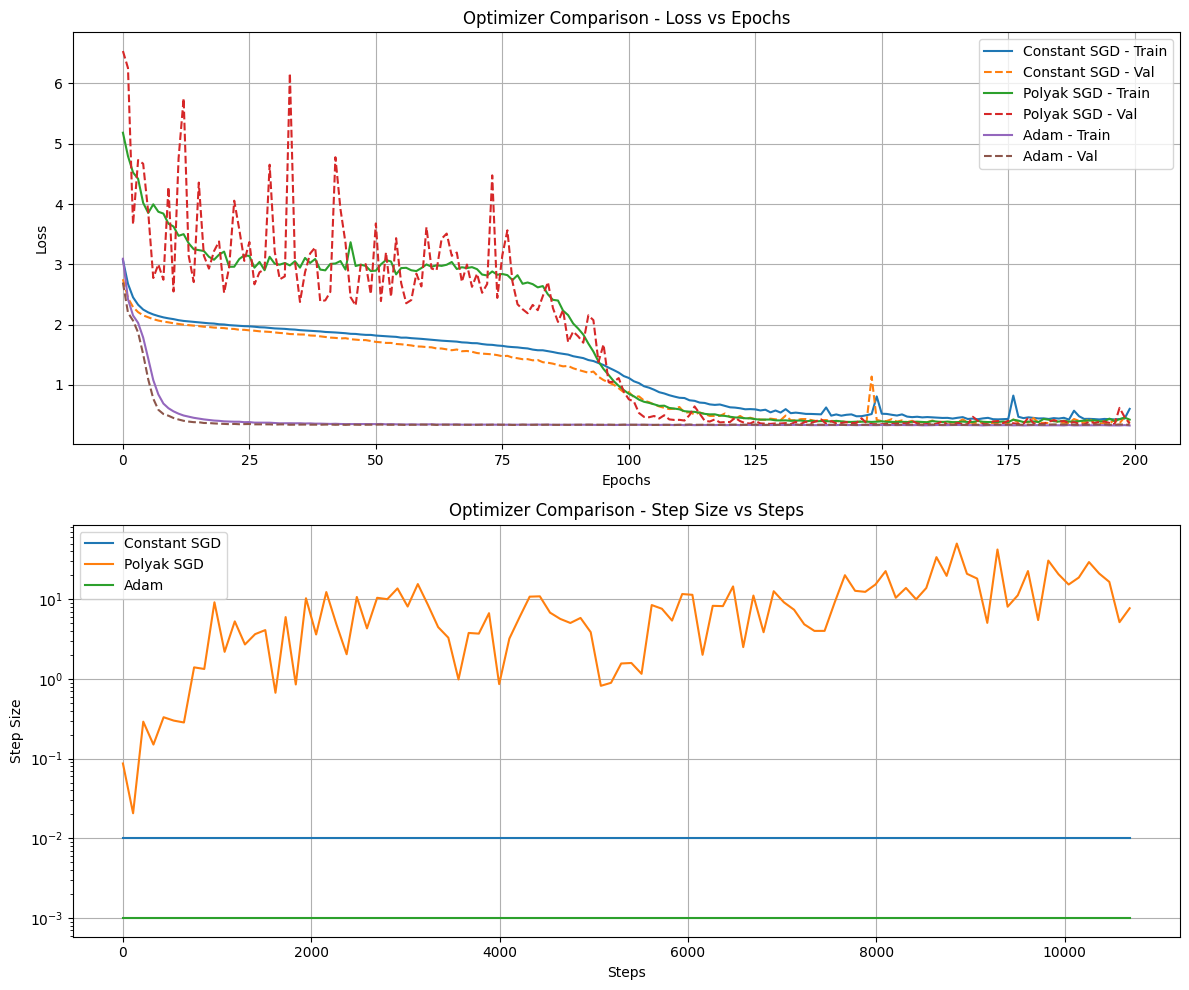

In [40]:
plot_results({
    'Constant SGD': sgd_results,
    'Polyak SGD': polyak_results,
    'Adam': adam_results
})


In [38]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)

print("\n--- Sample Outputs ---")
print("\n[SGD]:\n", decode(sgd_model.generate(context, max_new_tokens=100)[0].tolist()))
print("\n[Polyak]:\n", decode(polyak_model.generate(context, max_new_tokens=100)[0].tolist()))
print("\n[Adam]:\n", decode(adam_model.generate(context, max_new_tokens=100)[0].tolist()))



--- Sample Outputs ---

[SGD]:
 
I love you Where ball
Read book No mine No like
My teddy Shoes on
I washands Saw big fluffy doggy at

[Polyak]:
 
I want cookie No like it
Shoes on I run fast
I want cookie I did it
I wash hands Daddy play
I want t

[Adam]:
 
I did it No like it
I dance Daddy play
More bubbles No touch
Bath time I jump high
Where ball I wash
